In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import copy
import datetime as dt
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
test_df.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   int64  
 1   battery_power  1000 non-null   int64  
 2   blue           1000 non-null   int64  
 3   clock_speed    1000 non-null   float64
 4   dual_sim       1000 non-null   int64  
 5   fc             1000 non-null   int64  
 6   four_g         1000 non-null   int64  
 7   int_memory     1000 non-null   int64  
 8   m_dep          1000 non-null   float64
 9   mobile_wt      1000 non-null   int64  
 10  n_cores        1000 non-null   int64  
 11  pc             1000 non-null   int64  
 12  px_height      1000 non-null   int64  
 13  px_width       1000 non-null   int64  
 14  ram            1000 non-null   int64  
 15  sc_h           1000 non-null   int64  
 16  sc_w           1000 non-null   int64  
 17  talk_time      1000 non-null   int64  
 18  three_g  

In [7]:
X = train_df.drop(columns = ['price_range'])
y = train_df['price_range']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_df.drop(columns = ['id']))

In [10]:
type(X_train_scaled)

numpy.ndarray

In [17]:
class PhoneDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y.to_numpy()).float()
        self.y = self.y.type(torch.LongTensor)
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 4)
        self.softmax = nn.Softmax(dim = 1)

    def forward (self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [13]:
net = NeuralNetwork()
print(net)

NeuralNetwork(
  (fc1): Linear(in_features=20, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)


In [14]:
class Trainer():
   def __init__(self,  dataset, net, loss_f, learning_rate=1e-3, 
                epoch_amount=10, batch_size=2, 
                max_batches_per_epoch=None,
                device='cpu', early_stopping=10, 
                optim=torch.optim.Adam, 
                scheduler=None, permutate=True):
       self.loss_f = loss_f
       self.learning_rate = learning_rate
       self.epoch_amount = epoch_amount
       self.batch_size = batch_size
       self.max_batches_per_epoch = max_batches_per_epoch       
       self.device = device
       self.early_stopping = early_stopping
       self.optim = optim
       self.scheduler = scheduler
       self.permutate = permutate
       self.dataset = dataset
       self.start_model = net
       self.best_model = net
       
       self.train_loss = []
       self.val_loss = []
       self.train_accuracies = []
       self.val_accuracies = []
       
   def predict (self, X):
        return self.best_model(X)

   def fit(self, X_train, X_test, y_train, y_test):
        
        Net = self.start_model
        device = torch.device(self.device)

        Net.to(self.device)

        optimizer = self.optim(Net.parameters(), lr = self.learning_rate)

        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        train = self.dataset(X_train, y_train)
        val = self.dataset(X_test, y_test)
        train = DataLoader(train, batch_size = self.batch_size, shuffle = self.permutate)
        val = DataLoader(val, batch_size = self.batch_size, shuffle = False)

        best_val_loss = float('inf') 
                                     
        best_ep = 0                   

        correct = 0
        num = 0


        for epoch in range(self.epoch_amount): 
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0
            batch_n = 0

            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break
                optimizer.zero_grad()

                batch_X = batch_X.to(self.device)
                #target = F.one_hot(target, num_classes=4)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1

                _, preds = torch.max(predicted_values, 1)
                correct += (preds == target).sum().item()
                num += target.size(0)

            accuracy =  correct / num
            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            self.train_accuracies.append(accuracy)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')
            print(f'train_accuracy: {accuracy}')
            
            Net.eval()
            mean_loss = 0
            batch_n = 0

           

            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)

                mean_loss += float(loss)
                batch_n += 1
                
                _, preds = torch.max(predicted_values, 1)
                correct += (preds == target).sum().item()
                num += target.size(0)
            
            accuracy =  correct / num
            mean_loss /= batch_n
            #accuracy = correct / num
            self.val_loss.append(mean_loss)
            self.val_accuracies.append(accuracy)
            
            print(f'Loss_val: {mean_loss}')
            print(f'test_accuracy: {accuracy}')
            

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()
        

In [19]:
params = {
    'dataset': PhoneDataset,
    'net': net,
    'epoch_amount': 300, 
    'learning_rate': 1e-2,
    'early_stopping': 25,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.SGD,
}

clf = Trainer(**params)
clf.fit(X_train_scaled, X_val_scaled, y_train, y_val)

Эпоха: 0 Loss_train: 1.3868994842256819, 0:00:00.367837 сек
train_accuracy: 0.27
Loss_val: 1.3869045972824097
test_accuracy: 0.26961483594864477

Эпоха: 1 Loss_train: 1.3679558302674975, 0:00:00.363833 сек
train_accuracy: 0.32012847965738755
Loss_val: 1.372094988822937
test_accuracy: 0.3202567760342368

Эпоха: 2 Loss_train: 1.319982386146273, 0:00:00.378343 сек
train_accuracy: 0.3751189343482398
Loss_val: 1.3238877058029175
test_accuracy: 0.3751783166904422

Эпоха: 3 Loss_train: 1.2328060099056788, 0:00:00.378852 сек
train_accuracy: 0.40813414199072423
Loss_val: 1.22342848777771
test_accuracy: 0.4081669044222539

Эпоха: 4 Loss_train: 1.169642314485141, 0:00:00.364560 сек
train_accuracy: 0.4292237442922374
Loss_val: 1.1586233377456665
test_accuracy: 0.42924393723252496

Эпоха: 5 Loss_train: 1.1320376816817692, 0:00:00.367337 сек
train_accuracy: 0.4517241379310345
Loss_val: 1.118642807006836
test_accuracy: 0.45173561578697097

Эпоха: 6 Loss_train: 1.0995210593087332, 0:00:00.365332 сек
t

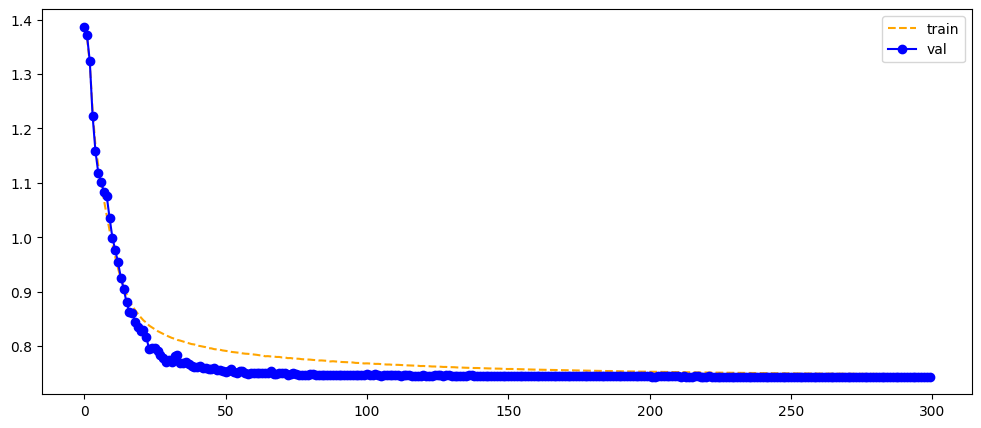

In [20]:
def plot_loss(Loss_train, Loss_val):
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    plt.plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    plt.legend()
    plt.show()

plot_loss(clf.train_loss, clf.val_loss)

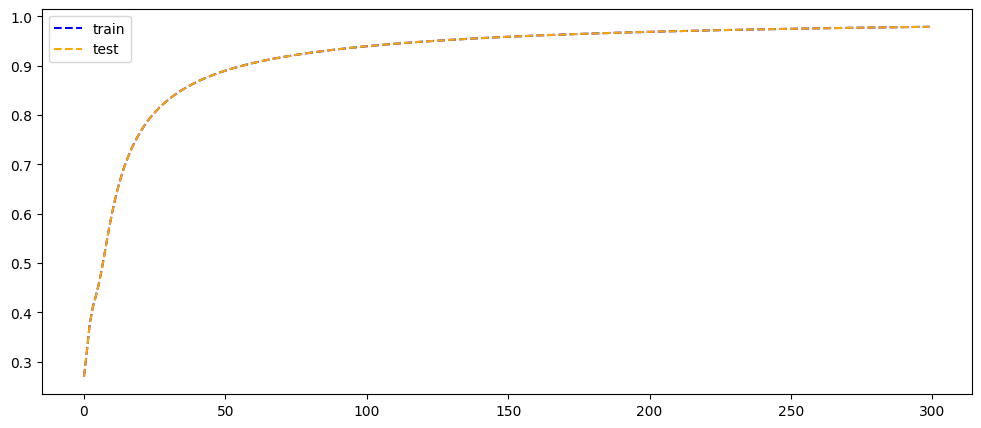

In [21]:
def accuracy_loss(train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(train_accuracies)), train_accuracies, color='blue', label='train', linestyle='--')
    plt.plot(range(len(val_accuracies)), val_accuracies, color='orange', label='test', linestyle='--')
    plt.legend()
    plt.show()

accuracy_loss(clf.train_accuracies, clf.val_accuracies)

In [31]:
predictions_prob = clf.predict(torch.Tensor(X_test_scaled))
predictions = np.argmax(predictions_prob.detach().numpy(), axis=1)

In [32]:
result_df = test_df.copy()
result_df['predicted_class'] = predictions

In [33]:
result_df.head(20)

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,predicted_class
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,226,1412,3476,12,7,2,0,1,0,2
1,2,841,1,0.5,1,4,1,61,0.8,191,...,746,857,3895,6,0,7,1,0,0,3
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,1270,1366,2396,17,10,10,0,1,1,2
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,295,1752,3893,10,0,7,1,1,0,3
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,749,810,1773,15,8,7,1,0,1,1
5,6,1464,1,2.9,1,5,1,50,0.8,198,...,569,939,3506,10,7,3,1,1,1,3
6,7,1718,0,2.4,0,1,0,47,1.0,156,...,1283,1374,3873,14,2,10,0,0,0,3
7,8,833,0,2.4,1,0,0,62,0.8,111,...,1312,1880,1495,7,2,18,0,1,1,1
8,9,1111,1,2.9,1,9,1,25,0.6,101,...,556,876,3485,11,9,10,1,1,0,3
9,10,1520,0,0.5,0,1,0,25,0.5,171,...,52,1009,651,6,0,5,1,0,1,0
